In [1]:
import copy
import pathlib

import pandas as pd
from preprocessing.pipeline import (
    combine_data_NYPD,
    get_preprocessed_data,
    preprocess_311,
    process_crime_data,
    query_data,
)
from preprocessing.weather_parse import weather_parse


In [2]:
year = 2017
preprocessed_dir = pathlib.Path(f"../data/combined/year={year}")

try:
    df = pd.read_parquet(
        preprocessed_dir,
        )
    assert len(df) != 0
except AssertionError:
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')
    df.to_parquet(preprocessed_dir)
except FileNotFoundError:
    preprocessed_dir.mkdir()
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')

    df.to_parquet(preprocessed_dir)
except ValueError:
    boroughs = []
    for file_path in preprocessed_dir.glob('*'):

        if file_path.is_dir():
            try:
                boroughs.append(pd.read_parquet(file_path))
                # print(df)
            except Exception:
                print(file_path)

    df = pd.concat(boroughs)
df

,borough,precinct,complaint_type,created_H,closed_H,created_date,closed_date,agency,descriptor,status,...,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,year,date_H,FELONY,MISDEMEANOR,VIOLATION
0,BRONX,40.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:47:15,2017-01-01 09:22:44,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,18,3
1,BRONX,43.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 14:00:00,2017-01-01 00:48:20,2017-01-01 14:12:14,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
2,BRONX,43.0,Drug Activity,2017-01-01 00:00:00,2017-01-01 06:00:00,2017-01-01 00:19:10,2017-01-01 06:07:03,NYPD,Use Indoor,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
3,BRONX,43.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 05:00:00,2017-01-01 00:47:44,2017-01-01 05:46:55,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
4,BRONX,44.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:26:29,2017-01-01 09:41:39,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489182,BROOKLYN,72.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:14:44,2018-12-31 23:31:57,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489183,MANHATTAN,19.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:39:13,2018-12-31 23:52:08,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489184,MANHATTAN,25.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:36:36,2018-12-31 23:51:07,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489185,MANHATTAN,34.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:11:23,2018-12-31 23:15:41,NYPD,Banging/Pounding,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0


In [3]:
df.dtypes

borough                                  string[pyarrow]
precinct                                 string[pyarrow]
complaint_type                           string[pyarrow]
created_H                         timestamp[ns][pyarrow]
closed_H                          timestamp[ns][pyarrow]
created_date                      timestamp[ns][pyarrow]
closed_date                       timestamp[ns][pyarrow]
agency                                   string[pyarrow]
descriptor                               string[pyarrow]
status                                   string[pyarrow]
resolution_description                   string[pyarrow]
resolution_action_updated_date    timestamp[ns][pyarrow]
due_date                          timestamp[ns][pyarrow]
latitude                                 double[pyarrow]
longitude                                double[pyarrow]
hours_to_complete                        double[pyarrow]
created                                   int64[pyarrow]
created_bo                     

In [4]:
import datetime
import pathlib
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from lifelines import CoxPHFitter
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
)
from sklearn.inspection import permutation_importance
from sksurv.util import Surv
from statsmodels.duration.hazard_regression import PHReg, PHRegResults
import multiprocessing as mp
from preprocessing.pre_survival import strata_threshold_remove, process_categorical, prep_data_for_surv_analysis

In [5]:
## HYPERPARAMETERS ##
add_datetime_cols = True
seed = 14
strata = ["borough"]
target_col = "hours_to_complete"
status_col = "resolution_class"
datetime_col = "created_H"
root_save_dir = pathlib.Path("../models/survival_forest/")

save_name = input("Input a name for this model or leave blank to use a hash of the model results")
max_depth = 4
cpu_prop = 0.5
remove_cols = {
      'descriptor', 'resolution_description',
      'resolution_action_updated_date',
      'incident_zip', 'city', 'bbl','status',
      'closed_H','created_date',
      'closed_date','sector',
      'due_date','created','date_H',
      # 'created', 'created_bo', 'created_ag', 'created_co',
      # 'created_bo_ag', 'open', 'open_bo', 'open_ag', 'open_co',
      # 'open_bo_ag','open_bo_co',
      'precip_period_hrs', 'precip_accumulation_mm','direction_deg',
      'agency'
   #    'latitude', 'longitude',
   #    'created_bo_co','temperature_c','speed_mps','dew_temperature_c'
}

In [6]:

try:
    if not save_name:
        raise FileNotFoundError
    save_path = root_save_dir/f"{save_name}"

    rsf = joblib.load(root_save_dir/f"{save_name}"/"rsf.pickle")
    with (save_path/"hyper.json").open("r") as f:
        hyper = json.load(f)

    X_train, X_test, y_train, y_test = prep_data_for_surv_analysis(df,**hyper)
except FileNotFoundError:
    (root_save_dir/f"{save_name}").mkdir()

    X_train, X_test, y_train, y_test = prep_data_for_surv_analysis(
        df,
        remove_cols=remove_cols,
        strata=strata,
        target_col=target_col,
        status_col=status_col,
        year=year,
        add_datetime_cols=True,
        seed=seed,
        datetime_col=datetime_col
    )
    assert 0 < cpu_prop <= 1
    n_jobs = int(mp.cpu_count() * cpu_prop)
    rsf = RandomSurvivalForest(max_depth=3, min_samples_leaf=50, n_jobs=n_jobs, random_state=14)
    rsf.fit(X_train, y_train)
    if not save_name:
        save_name = datetime.datetime.now().strftime(r"%d%m%Y_%H%M")
    save_path = root_save_dir/f"{save_name}"
    joblib.dump(rsf, save_path/"rsf.pickle")
    hyper = {
        "workers":n_jobs,
        "add_datetime_cols":add_datetime_cols,
        "seed":seed,
        "strata":strata,
        "target_col": target_col,
        "status_col":status_col,
        "datetime_col":datetime_col,
        "max_depth": max_depth,
        "remove_cols":list(remove_cols),
        "year":year
    }
    with (save_path/"hyper.json").open("x") as f:
        json.dump(hyper, f, indent=4)


Dropped borough    22
dtype: int64 entries from strata below threshold 50


ArrowException: Unknown error: Wrapping                                                                               

In [ ]:
surv = rsf.predict_survival_function(X_test[:10000], return_array=True)

NameError: name 'rsf' is not defined

In [ ]:
X_test.iloc[4].loc[(X_test.iloc[4] != 0)]

complaint_type_Noise - Residential          1.0
precinct_67.0                               1.0
latitude                              40.650701
longitude                              -73.9519
created_bo                                 76.0
created_pr                                  6.0
created_co                                 80.0
created_bo_pr                               6.0
created_bo_co                              27.0
created_pr_co                               3.0
created_bo_pr_co                            3.0
open                                      676.0
open_bo                                   211.0
open_pr                                    14.0
open_co                                   191.0
open_bo_pr                                 14.0
open_bo_co                                 58.0
open_pr_co                                  7.0
open_bo_pr_co                               7.0
temperature_c                              26.7
speed_mps                               

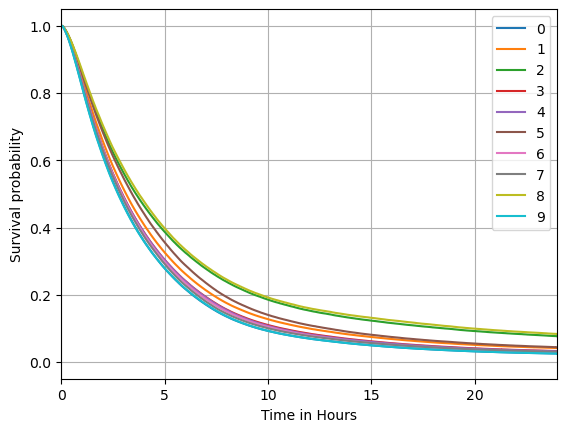

In [ ]:
for i, s in enumerate(surv[:10]):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in Hours")
plt.legend()
plt.xlim((0,24))
plt.grid(True)

In [ ]:
result = permutation_importance(rsf, X_test[:10], y_test[:10], n_repeats=15, random_state=seed, n_jobs=1)

In [ ]:
imp_df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

In [ ]:
imp_df.loc[(imp_df['importances_mean'] != 0)]

,importances_mean,importances_std
longitude,0.080303,0.066839
precinct_44.0,0.063636,0.040825
open_bo_pr,0.051515,0.025534
open_pr,0.046970,0.026849
open_pr_co,0.016667,0.010050
open_bo_pr_co,0.010606,0.011338
latitude,0.009091,0.036927
created_bo_pr,0.009091,0.011134
day_of_week,0.004545,0.009091
complaint_type_Noise - Residential,0.001515,0.005669


In [ ]:
# for name, data in sdf.groupby(strata):
#     if len(data) < 20:
#         continue
#     x_data = data[[c for c in data.columns if c not in strata and c != 'hours_to_complete']]
#     y = Surv.from_arrays(event=np.ones(len(data),dtype=bool), time= data["hours_to_complete"].to_numpy())
#     data_train, data_test, y_train, y_test = train_test_split(
#         x_data, y,
#         train_size=0.8,
#         test_size=0.2,
#         random_state=seed,
#     )
#     # y_train = Surv.from_arrays(y_train[:,0], y_train[:,1])
#     rsf.fit(data_train, y_train)
#     surv = rsf.predict_survival_function(data_test, return_array=True)
#     pred = rsf.predict(data_test)
#     break